# Customer Behaviours on Starbucks Rewards

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


In [20]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

In [21]:
# read in the json files
#portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
#profile = pd.read_json('data/profile.json', orient='records', lines=True)
#transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Analyze portfolio data

In [22]:
# Load portfolio data
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
# Print portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [24]:
# Calculate null values in portfolio dataframe
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**From above, we can observe that there are no null values in portfolio dataframe**.

In [25]:
# Change name of feature id to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [26]:
# Compute count of offert type
portfolio.groupby(['offer_type'])['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

**From above , we can observe that there are 3 offer types i.e. 4 bogo offers, 4 discount offers and 2 informational offers**.

In [27]:
# Calculate unique values of feature offer_type
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [28]:
# Calculate offer id's for each offer type
bogo_id = portfolio[portfolio['offer_type'] == 'bogo']['offer_id'].values.tolist()
print("bogo id's are: {}\n".format(bogo_id))
discount_id = portfolio[portfolio['offer_type'] == 'discount']['offer_id'].values.tolist()
print("discount id's are: {}\n".format(discount_id))
inform_id = portfolio[portfolio['offer_type'] == 'informational']['offer_id'].values.tolist()
print("informational id's are: {}".format(inform_id))

bogo id's are: ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'f19421c1d4aa40978ebb69ca19b0e20d']

discount id's are: ['0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '2906b810c7d4411798c6938adc9daaa5']

informational id's are: ['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837']


In [29]:
# Convert time feature from days to hours
portfolio['duration'] = portfolio['duration']*24

# Make separate columns for values in feature channels list
portfolio['web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))

# Drop channels column
portfolio.drop(columns=['channels'],axis=1, inplace=True)

# OneHotEncoding fetaure offer_type
portfolio = pd.get_dummies(portfolio, columns=['offer_type'], prefix='', prefix_sep='')

# Re-order columns of portfolio dataframe
col_order = ['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational', 'web', 'email',\
             'mobile', 'social']
portfolio = portfolio.reindex(col_order, axis=1)

# Print portfolio dataframe
portfolio

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,10,168,10,1,0,0,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,5,1,0,0,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,5,0,1,0,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,3,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,0,1,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,120,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,168,2,0,1,0,1,1,1,0


In [30]:
# Print shape of portfolio dataframe
portfolio.shape

(10, 11)

In [31]:
# Print features of portfolio dataframe
portfolio.columns

Index(['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount',
       'informational', 'web', 'email', 'mobile', 'social'],
      dtype='object')

## Analyze profile data

In [33]:
# Load profile data 
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [34]:
# Print profile dataframe info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [35]:
# Print shape of profile dataframe
profile.shape

(17000, 5)

In [36]:
# Calculate null values in profile dataframe
profile.isnull().sum(0)

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

**From above, we can observe that gender and income features each have 2175 null values**.

In [37]:
# Calculate count of unique id i.e. customers
len(profile['id'].unique())

17000

In [38]:
# Change name of feature id to customer_id in profile dataframe
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [39]:
# Calculate count of unique id i.e. customers
len(profile['customer_id'].unique())

17000

In [40]:
# Calculate count of unique gender
profile['gender'].value_counts().sort_values(ascending=False)

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [41]:
# Calculate count of unique age
profile['age'].value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
       ... 
22      131
21      140
20      135
19      135
18       70
Name: age, Length: 85, dtype: int64

**From above, we can observe that there are 2175 observations with age 118 which is also the maximum age. The number of observations for this age is way too much than the number of observations for second highest age 101 which is only 5 which indicates that there are more people with age 118 than with age 101 which seems unrealistic. Also, the number of observations with age 118 i.e. 2175 is equal to the number of missing values in features gender and income. Let us analyse the profile data for age 118 more**.

In [42]:
# Print few records of profile dataframe for age 118
profile_age_118 = profile[profile['age'] == 118]
profile_age_118.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [43]:
# Number of observations with age 118
profile_age_118.shape[0]

2175

In [44]:
# Calculate unique customer_id's with age 118
len(profile[profile['age'] == 118]['customer_id'].unique())

2175

**From above, we can observe that there are 2175 unique customers with age 118**.

In [45]:
# Analyze gender feature of customers with age 118
print(profile_age_118['gender'].unique()[0])
print(profile_age_118['gender'].shape[0])

None
2175


In [46]:
# Analyze income features of customers with age 118
print(profile_age_118['income'].unique()[0])
print(profile_age_118['income'].shape[0])

nan
2175


**From above, we can observe that all customers with age 118 have gender as None and income as nan i.e. all customers with age 118 has missing values in gender and income features. Also, only customers with age 118 corresponds to missing values in gender and income features in profile dataframe**.

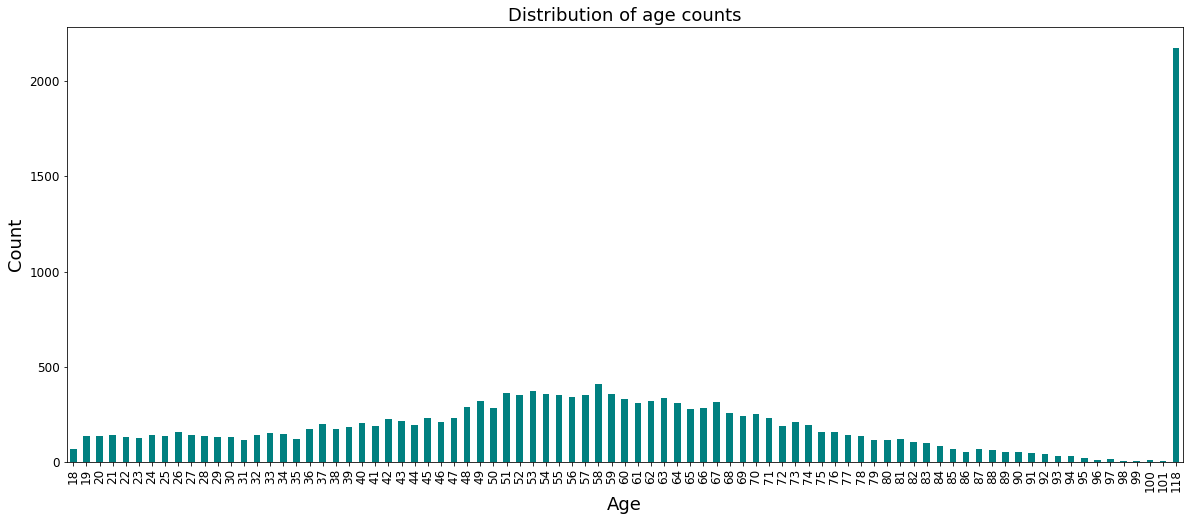

In [47]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,8), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts', fontsize=18)
plt.show()

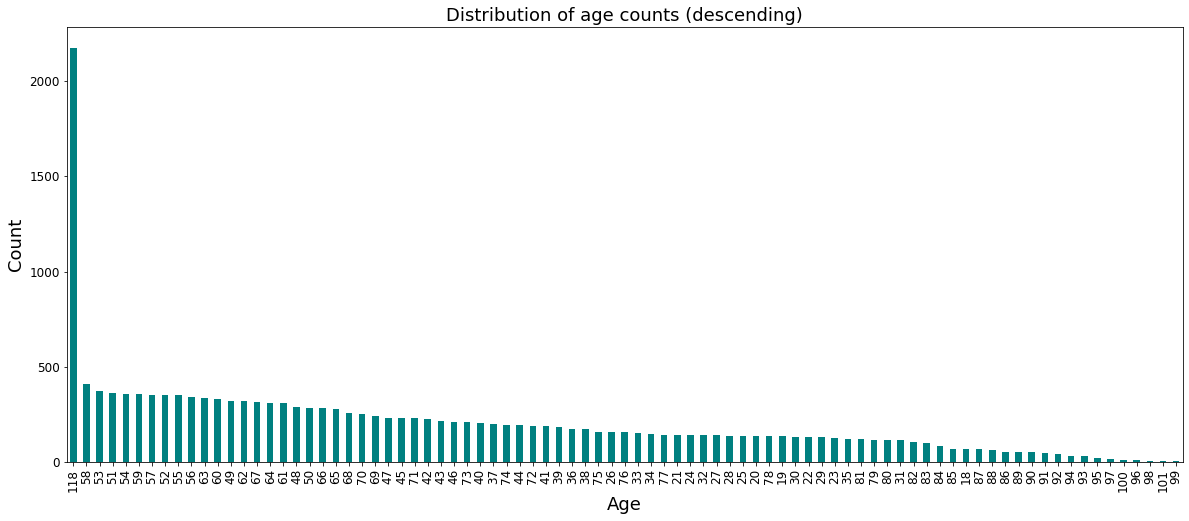

In [48]:
# Plot distribution of ages count in profile dataframe in descending order
profile['age'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20,8), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts (descending)', fontsize=18)
plt.show()

**From above, we can cleary see that customers with age 118 clearly stand out in distribution plot. Therefore, dropping these customers from profile dataframe as these customers do not have any gender and income and also the number of customers with age 118 which is 2175 is unrealistic**.

In [49]:
# Remove customers with age 118
profile.drop(index=profile_age_118.index, inplace=True)
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [50]:
# Shape of profile dataframe after dropping customers with age 118
profile.shape

(14825, 5)

In [51]:
# Print profile dataframe info after removing customers with age 118
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   customer_id       14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


**From above, we can observe that after removing customer with age 118, there are no null values in any features of profile dataframe**.

#### Analyze feature 'age'

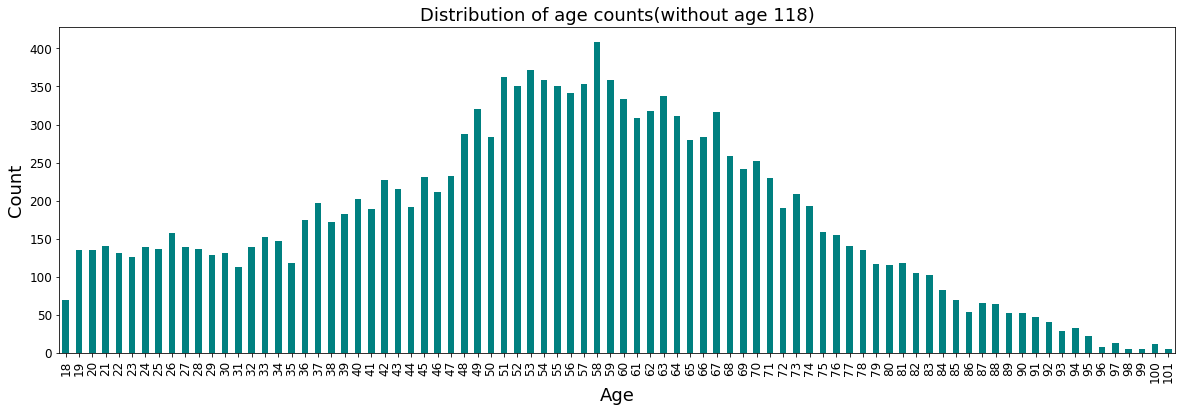

In [52]:
# Plot distribution of ages in profile dataframe after observations with age 118 has been dropped 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts(without age 118)', fontsize=18)
plt.show()

**From above plot, we can observe that the feature age after dropping age 118 is uniformly distributed**. 

In [53]:
# Convert fetaure 'age' into 'age_bins' & 'age_by_decade' which would be helpful in determining
# if a particular age is influenced more by an offer
profile['age_bins'] = pd.cut(profile['age'], bins=range(10,120,10), right=False)
profile['age_by_decade'] = pd.cut(profile['age'], bins=range(10,120,10),\
                                  right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])

In [54]:
profile.head()

,gender,age,customer_id,became_member_on,income,age_bins,age_by_decade
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,"[50, 60)",50s
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,"[70, 80)",70s
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,"[60, 70)",60s
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,"[60, 70)",60s
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,"[50, 60)",50s


In [55]:
# Print unique 'age_bins'
profile['age_bins'].unique()

[[50, 60), [70, 80), [60, 70), [20, 30), [40, 50), [30, 40), [90, 100), [80, 90), [10, 20), [100, 110)]
Categories (10, interval[int64, left]): [[10, 20) < [20, 30) < [30, 40) < [40, 50) ... [70, 80) < [80, 90) < [90, 100) < [100, 110)]

In [56]:
# Print value count of each unique 'age_bins'
profile['age_bins'].value_counts().sort_index()

[10, 20)       205
[20, 30)      1369
[30, 40)      1526
[40, 50)      2309
[50, 60)      3541
[60, 70)      2991
[70, 80)      1782
[80, 90)       831
[90, 100)      254
[100, 110)      17
Name: age_bins, dtype: int64

In [57]:
# Print unique 'age_by_decade'
profile['age_by_decade'].unique()

['50s', '70s', '60s', '20s', '40s', '30s', '90s', '80s', '10s', '100s']
Categories (10, object): ['10s' < '20s' < '30s' < '40s' ... '70s' < '80s' < '90s' < '100s']

In [58]:
# Print value count of each unique 'age_by_decade'
profile['age_by_decade'].value_counts().sort_index()

10s      205
20s     1369
30s     1526
40s     2309
50s     3541
60s     2991
70s     1782
80s      831
90s      254
100s      17
Name: age_by_decade, dtype: int64

**From above, we can observe that each unique 'age_bins' has a corresponding 'age_by_decade' value. Therefore, for 'age_bins' `[10, 20), [20, 30), [30, 40), [40, 50), [50, 60), [60, 70), [70, 80), [80, 90), [90, 100), [100, 110)` there is corresponding 'age_by_decade' value which is `[10s, 20s, 30s, 40s, 50s, 60s, 70s, 80s, 90s, 100s]`. Therefore, we can drop feature 'age_bins' and also original feature 'age'**.

In [59]:
# Drop feature 'age' & age_bins'
profile.drop(columns=['age', 'age_bins'], inplace=True)
profile.head()

,gender,customer_id,became_member_on,income,age_by_decade
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,50s
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,70s
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.0,60s
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,60s
12,M,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,50s


In [60]:
# OneHotEncoding feature 'age_by_decade'
profile = pd.get_dummies(profile, columns=['age_by_decade'], prefix='age', prefix_sep='_')
profile.head()

,gender,customer_id,became_member_on,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0,0,0,0,1,0,0,0,0,0
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0,0,0,0,0,0,1,0,0,0
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.0,0,0,0,0,0,1,0,0,0,0
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,0,0,0,0,0,1,0,0,0,0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,0,0,0,0,1,0,0,0,0,0


#### Analyze feature 'became_member_on'

In [61]:
# Print type of feature 'became_member_on'
type(profile['became_member_on'])

pandas.core.series.Series

In [62]:
# Convert type of feature 'became_member_on' to type Datetime
type(pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt)

pandas.core.indexes.accessors.DatetimeProperties

In [63]:
# Calculate year in which the customer became member
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True)

2013     274
2014     662
2015    1597
2016    3024
2017    5599
2018    3669
Name: became_member_on, dtype: int64

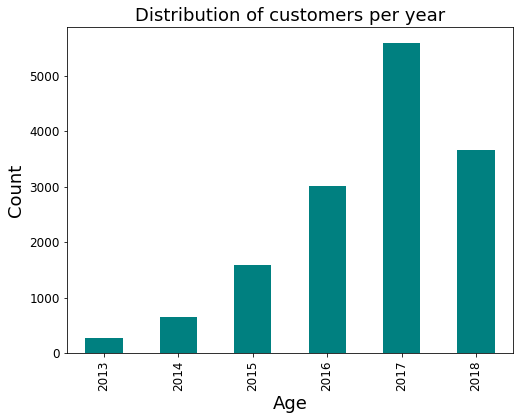

In [64]:
# Plot distribution of customer count per year in which the customer became member 
pd.to_datetime(profile['became_member_on'],\
               format='%Y%m%d').dt.year.value_counts().sort_index(ascending=True).plot.bar(figsize=(8,6),\
                                                                                           fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of customers per year', fontsize=18)
plt.show()

**From above, we can observe that the number of customers which became member increased every year except 2018. We are not sure, for how many months in 2018, the data was simulated. Therefore, we can conculde that the customer membership increased every year**. 

In [65]:
# Calculate month in which the customer became member
pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month.value_counts().sort_values(ascending=False)

8     1395
10    1386
12    1372
1     1327
9     1299
11    1268
7     1189
5     1152
4     1145
3     1145
6     1105
2     1042
Name: became_member_on, dtype: int64

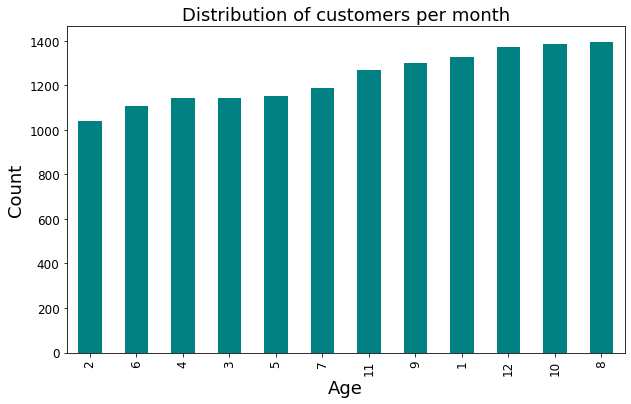

In [66]:
# Plot distribution of customer count per month in which the customer became member 
pd.to_datetime(profile['became_member_on'],\
               format='%Y%m%d').dt.month.value_counts().sort_values(ascending=True).plot.bar(figsize=(10,6),\
                                                                                           fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of customers per month', fontsize=18)
plt.show()

**From above, we can observe that customer membership increased during later cold season especially in (August, September, October, November, December, January) which makes sense too as customers have more coffee during cold weather**.

In [67]:
# Create feature 'membership_tenure' of customers from feature 'became_member_on'
profile['membership_tenure'] = (datetime.today().date() - pd.to_datetime(profile['became_member_on'],\
                                                                     format='%Y%m%d').dt.date).dt.days

# Create feature 'membership_year' in which customer became member from feature 'became_member_on'
profile['membership_year'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.year

# Create feature 'membership_month' in which customer became member from feature 'became_member_on'
profile['membership_month'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d').dt.month

# Drop feature 'became_member_on'
profile.drop(columns=['became_member_on'], axis=1, inplace=True)
profile.head()

,gender,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,age_100s,membership_tenure,membership_year,membership_month
1,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0,1604,2017,7
3,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0,1671,2017,5
5,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,0,0,1319,2018,4
8,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,0,0,1395,2018,2
12,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,0,0,1485,2017,11


#### Analyze feature 'gender'

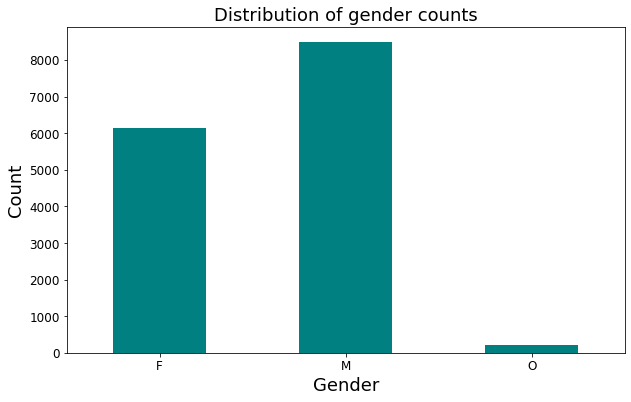

In [68]:
# Plot distribution of gender in profile dataframe
profile['gender'].value_counts().sort_index(ascending=True).plot.bar(figsize=(10,6), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title('Distribution of gender counts', fontsize=18)
plt.show()

**From above, we can observe that there are more males members than female members**.

In [69]:
# Create gender_by_year_df dataframe to be used to create visualization
gender_by_year_df = pd.DataFrame(profile.groupby(['membership_year'])['gender'].value_counts())
gender_by_year_df.rename(columns = {'gender': 'gender_count'}, inplace=True)
gender_by_year_df.reset_index(inplace=True)
gender_by_year_df

,membership_year,gender,gender_count
0,2013,M,197
1,2013,F,74
2,2013,O,3
3,2014,M,520
4,2014,F,138
5,2014,O,4
6,2015,M,905
7,2015,F,663
8,2015,O,29
9,2016,F,1509


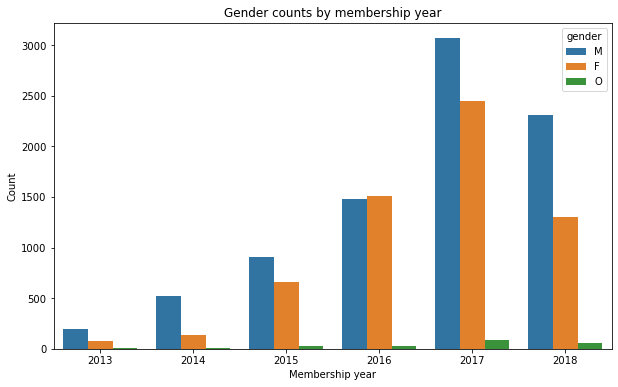

In [70]:
# PLot gender counts per membership year
fig, ax = plt.subplots(figsize=(10, 6),
                       nrows=1,
                       ncols=1)

sns.barplot(x='membership_year', y='gender_count', hue='gender', data=gender_by_year_df)
plt.xlabel('Membership year')
plt.ylabel('Count')
plt.title('Gender counts by membership year')
plt.show()

**From above plot, we can observe that male membership is either nearly equal or more than female membership. So, male membership is more than female membership which is more than others membership**.

#### Analyze feature 'income'

In [71]:
# Print unique values of feature income
np.sort(profile['income'].unique())

array([ 30000.,  31000.,  32000.,  33000.,  34000.,  35000.,  36000.,
        37000.,  38000.,  39000.,  40000.,  41000.,  42000.,  43000.,
        44000.,  45000.,  46000.,  47000.,  48000.,  49000.,  50000.,
        51000.,  52000.,  53000.,  54000.,  55000.,  56000.,  57000.,
        58000.,  59000.,  60000.,  61000.,  62000.,  63000.,  64000.,
        65000.,  66000.,  67000.,  68000.,  69000.,  70000.,  71000.,
        72000.,  73000.,  74000.,  75000.,  76000.,  77000.,  78000.,
        79000.,  80000.,  81000.,  82000.,  83000.,  84000.,  85000.,
        86000.,  87000.,  88000.,  89000.,  90000.,  91000.,  92000.,
        93000.,  94000.,  95000.,  96000.,  97000.,  98000.,  99000.,
       100000., 101000., 102000., 103000., 104000., 105000., 106000.,
       107000., 108000., 109000., 110000., 111000., 112000., 113000.,
       114000., 115000., 116000., 117000., 118000., 119000., 120000.])

In [72]:
# Print value counts for each unique income
profile['income'].value_counts().sort_index()

30000.0      88
31000.0     223
32000.0     216
33000.0     213
34000.0     199
           ... 
116000.0     46
117000.0     32
118000.0     58
119000.0     54
120000.0     13
Name: income, Length: 91, dtype: int64

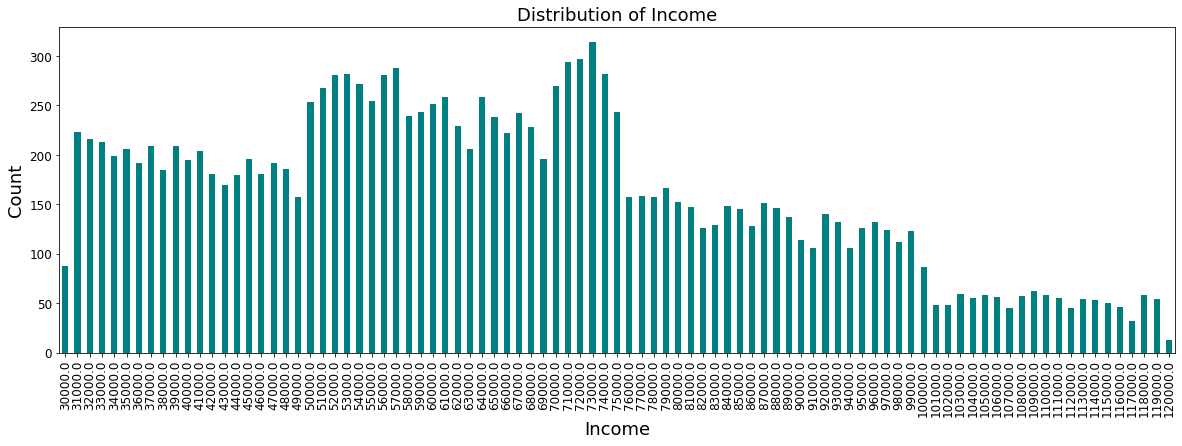

In [73]:
# Plot distribution of feature 'income' in profile dataframe
profile['income'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Income', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation='vertical')
plt.title('Distribution of Income', fontsize=18)
plt.show()

**From above plot, we can observe that income appears to be non-uniformaly distributed across income range and have low distribution with high income which seems reasonable**.

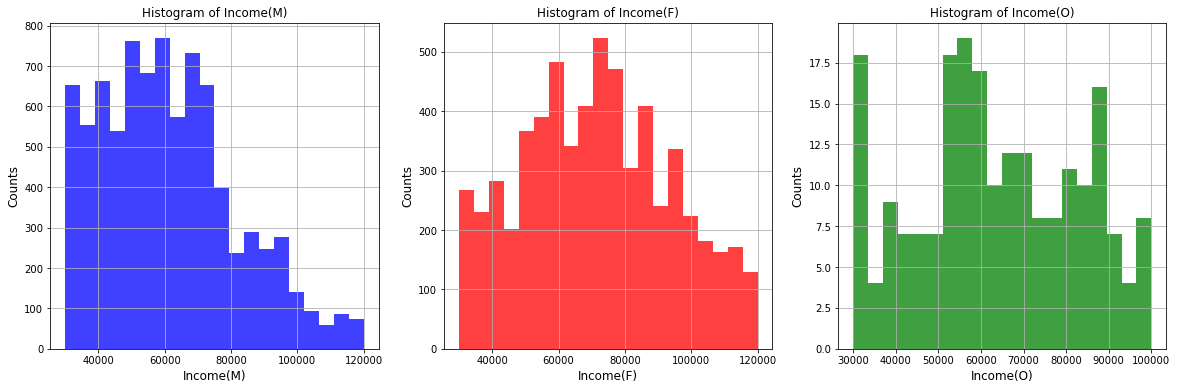

In [74]:
# Plot histograms of income per gender
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=3,
                       sharex=True,
                       sharey=True)

plt.subplot(131)
plt.hist(profile.loc[profile['gender'] == 'M', 'income'], bins=20, facecolor='b', alpha=0.75)
plt.xlabel('Income(M)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income(M)', fontsize=12)
plt.grid(True)

plt.subplot(132)
plt.hist(profile.loc[profile['gender'] == 'F', 'income'], bins=20, facecolor='r', alpha=0.75)
plt.xlabel('Income(F)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income(F)', fontsize=12)
plt.grid(True)

plt.subplot(133)
plt.hist(profile.loc[profile['gender'] == 'O', 'income'], bins=20, facecolor='g', alpha=0.75)
plt.xlabel('Income(O)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of Income(O)', fontsize=12)
plt.grid(True)

plt.show()

**From above, we can observe that the distribution of income per gender appears similar for males and females where minimum and maiximum income for both males and females is nearly same with male income slightly biased towards lower income. Also, income distribution for Others is also similar to males and females with minimum & maximum income less than (males & females)**.

In [75]:
# OneHotEncoding feature 'membership_year'
profile = pd.get_dummies(profile, columns=['membership_year'], prefix='', prefix_sep='')

# OneHotEncoding feature 'membership_month'
profile = pd.get_dummies(profile, columns=['membership_month'], prefix='month', prefix_sep='_')

# OneHotEncoding feature 'gender'
profile = pd.get_dummies(profile, columns=['gender'], prefix='', prefix_sep='')

profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [76]:
# Create bins of feature 'income'
pd.cut(profile['income'], bins=range(30000,140000,10000), right=False).values

[[110000, 120000), [100000, 110000), [70000, 80000), [50000, 60000), [50000, 60000), ..., [50000, 60000), [70000, 80000), [70000, 80000), [50000, 60000), [80000, 90000)]
Length: 14825
Categories (10, interval[int64, left]): [[30000, 40000) < [40000, 50000) < [50000, 60000) < [60000, 70000) ... [90000, 100000) < [100000, 110000) < [110000, 120000) < [120000, 130000)]

In [77]:
# Convert feature 'income' into 'income_by_range' which would be helpful in determining
# if a particular income range is influenced more by an offer
profile['income_by_range'] = pd.cut(profile['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                            '100ths', '110ths', '120ths'])
profile.head()

,customer_id,income,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,...,month_7,month_8,month_9,month_10,month_11,month_12,F,M,O,income_by_range
1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,110ths
3,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,100ths
5,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,70ths
8,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,50ths
12,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,50ths


In [78]:
# Print unique values of feature 'income_by_range'
profile['income_by_range'].value_counts().sort_index(ascending=True)

30ths     1940
40ths     1841
50ths     2661
60ths     2328
70ths     2338
80ths     1409
90ths     1215
100ths     575
110ths     505
120ths      13
Name: income_by_range, dtype: int64

**From above, we can observe that for each income bin there is a label i.e. for bins `[30000, 40000) < [40000, 50000) < [50000, 60000) < [60000, 70000) < [70000, 80000) < [80000, 90000) < [90000, 100000) < [100000, 110000) < [110000, 120000) < [120000, 130000)]` there is a label which are `['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths', '100ths', '110ths', '120ths']`. Therefore, we can drop feature 'income'**.

In [79]:
# Drop feature 'income'
profile.drop(columns=['income'], inplace=True)

In [80]:
# OneHotEncoding feature 'income_by_range'
profile = pd.get_dummies(profile, columns=['income_by_range'], prefix='income', prefix_sep='_')
profile.head()

,customer_id,age_10s,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_80s,age_90s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [81]:
# Print column names of profile dataframe
profile.columns

Index(['customer_id', 'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s',
       'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',
       'membership_tenure', '2013', '2014', '2015', '2016', '2017', '2018',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'F', 'M', 'O', 'income_30ths', 'income_40ths', 'income_50ths',
       'income_60ths', 'income_70ths', 'income_80ths', 'income_90ths',
       'income_100ths', 'income_110ths', 'income_120ths'],
      dtype='object')

In [82]:
# Print number of columns
len(profile.columns)

43

In [83]:
# Re-order columns of profile dataframe
profile_col_order = ['customer_id', 'membership_tenure', 'F', 'M', 'O',\
                     'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s',\
                     'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',\
                     '2013', '2014', '2015', '2016', '2017', '2018',\
                     'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',\
                     'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',\
                     'income_30ths', 'income_40ths', 'income_50ths','income_60ths', 'income_70ths',\
                     'income_80ths', 'income_90ths','income_100ths', 'income_110ths', 'income_120ths']

profile = profile.reindex(profile_col_order, axis=1)
profile.head()

,customer_id,membership_tenure,F,M,O,age_10s,age_20s,age_30s,age_40s,age_50s,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,0610b486422d4921ae7d2bf64640c50b,1604,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,78afa995795e4d85b5d9ceeca43f5fef,1671,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,e2127556f4f64592b11af22de27a7932,1319,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,389bc3fa690240e798340f5a15918d5c,1395,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,1485,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [84]:
# Print shape of profile dataframe
profile.shape

(14825, 43)

## Analyze transcript data

In [87]:
# Load transcript data
transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [88]:
# Print transcript dataframe info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [89]:
# Print shape of transcript dataframe
transcript.shape

(306534, 4)

In [90]:
# Calculate null values in transcript dataframe
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

**From above, we can observe that there is no null values in transcript dataframe**.

In [91]:
# # Change name of feature person to customer_id in transcript dataframe
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [92]:
# Compute number of observations in transcript dataframe with customers having age 118
id_age_118 = profile_age_118['customer_id'].unique().tolist()
print(transcript['customer_id'].isin(id_age_118).value_counts())

False    272762
True      33772
Name: customer_id, dtype: int64


In [93]:
# Percentage of observations in transcript dataframe with customers having age 118
round((transcript['customer_id'].isin(id_age_118).sum()/transcript.shape[0])*100,2)

11.02

**From above, we observe that there are 11.02 % i.e. 33772 observations in transcript dataframe which belong to customers with age 118. Therefore, removing observations with customers having age 118 as we will still have around 89% of data for further analysis**.

In [94]:
# Remove observations having customers with age 118 from transcript dataframe
transcript = transcript[~transcript['customer_id'].isin(id_age_118)]
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [95]:
# Shape of trancript dataframe after removing observations of customers with age 118
transcript.shape

(272762, 4)

In [96]:
# Check if customers with age 118 has been removed from transcript dataframe
transcript['customer_id'].isin(id_age_118).sum()

0

**From above, we can observe that transcript dataframe has 0 observations with age 118**.

In [97]:
# Check if all the customers in profile dataframe are also in transcript dataframe
len(set(transcript['customer_id'].unique()) - set(profile['customer_id'].unique()))

0

**From above, we can observe that all the customers in profile dataframe have atleast one observation in transcript data i.e. all the customers in profile dataframe are also in transcript dataframe**.

In [98]:
# Calculate unique values in event feature
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [99]:
# Calculate the percentage of unique values in event feature
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.45
offer received     24.38
offer viewed       18.28
offer completed    11.89
Name: event, dtype: float64

**From above, we can observe that there are 45.45% of events as transactions, 24.38% of events as offers received, 18.28% of events as offers viewed and 11.89 % of events as offers completed. We need to separate events with type 'transactions' and 'offers' to be used later on for analysis**.

In [100]:
# Calculate percentage of transaction and offer events
event_transaction = transcript['event'].value_counts()[0]
event_offers = transcript['event'].value_counts()[1:].sum()
event_total = transcript['event'].shape[0]

print('Percentage of transaction events are: {}%'.format(round((event_transaction/event_total)*100,2)))
print('Percentage of offers events are: {}%'.format(round((event_offers/event_total)*100,2)))

Percentage of transaction events are: 45.45%
Percentage of offers events are: 54.55%


In [101]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [102]:
# Print features of transcript dataframe
transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

## Create Offers and transaction dataframe

In [103]:
# Create dataframe offers_df containing only offers events and transaction_df containing only transaction event
# Create a list of offer event types
offer_event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = transcript[transcript['event'].isin(offer_event_list)].index

# Find index where feature event is 'transaction'
transaction_index = transcript[~transcript['event'].isin(offer_event_list)].index

# Create offers_df
offers_df = transcript.loc[offer_index,:]

# Create transaction_df
transaction_df = transcript.loc[transaction_index,:]

In [104]:
# Print unique values in feature event in offers_df
offers_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [105]:
# Print unique values in feature event in transaction_df
transaction_df['event'].unique()

array(['transaction'], dtype=object)

**From above, we can observe that dataframe offers_df contains only events 'offer received', 'offer viewed' and 'offer completed' and dataframe transaction_df contains only event 'transaction'**.

In [106]:
# Print value counts in feature offers_df
offers_df['event'].value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

In [107]:
# Print value counts in feature transaction_df
transaction_df['event'].value_counts()

transaction    123957
Name: event, dtype: int64

In [108]:
# Print total number of observations in offers_df and transction_df
offers_df.shape[0] + transaction_df.shape[0]

272762

In [109]:
# Create function to retrieve offer_id from feature value
def func_value_offer_id(x):
    for k,v in x.items():
        if k in ['offer id','offer_id']:
            return str(v)
        elif k not in ['offer id','offer_id', 'reward']:
            print('key {} not in dict'.format(k))

In [110]:
# Create column 'offer_id' and filling in the values using function func_value_offer_id
offers_df.loc[:,'offer_id'] = offers_df['value'].apply(func_value_offer_id)

In [111]:
offers_df.head()

,customer_id,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [112]:
# Print unique offer_id in offers_df
offers_df['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [113]:
# Create another column 'offer_type' with respect to feature 'offer_id'
offers_df['offer_type'] = offers_df['offer_id'].copy()



offers_df['offer_type'].replace(['ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',\
                                 '9b98b8c7a33c4b65b9aebfe6a799e6d9','f19421c1d4aa40978ebb69ca19b0e20d'],\
                                 'bogo', inplace=True)

offers_df['offer_type'].replace(['0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',\
                                 'fafdcd668e3743c1bb461111dcafc2a4','2906b810c7d4411798c6938adc9daaa5'],\
                                 'discount', inplace=True)

offers_df['offer_type'].replace(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'],\
                                 'informational', inplace=True)

offers_df.head()

,customer_id,event,value,time,offer_id,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,discount
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,informational
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


In [114]:
# Calculate the count of customers by grouping offer type and event
offers_df.groupby(['offer_type', 'event'])['customer_id'].count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: customer_id, dtype: int64

**From above, we can observe that offer type 'bogo' and 'discount' has event 'offer received', 'offer viewed' and 'offer completed' whereas offer type 'informational' has only event 'offer received' and 'offer viewed'. Therefore, for offer type 'bogo' and 'discount', we will consider the offer as completed when there would be an event 'offer viewed' followed by 'offer completed' within the offer period whereas for offer type 'informational', we will consider it as completed when a customer makes a purchase transaction after viewing the informational offer within the offer period**.

In [115]:
# Transform offers_df
# Drop feature value as it is not required now and drop feature offer_type as that information is also in portfolio dataframe
# as well
offers_df.drop(columns=['value', 'offer_type'], inplace=True)

# OneHotEncoding feature 'income_by_range'
offers_df = pd.get_dummies(offers_df, columns=['event'], prefix='', prefix_sep='')

# Change column names
offers_df.rename(columns = {'offer received': 'offer_recd',
                            'offer viewed': 'offer_view',
                            'offer completed': 'offer_comp'}, inplace=True)

# Re-order columns of offers_df dataframe
offers_df_col_order = ['customer_id', 'offer_id', 'time', 'offer_recd', 'offer_view', 'offer_comp']

offers_df = offers_df.reindex(offers_df_col_order, axis=1)
offers_df.head()

,customer_id,offer_id,time,offer_recd,offer_view,offer_comp
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [116]:
# Transform transaction_df
# Create column 'amount'
transaction_df.loc[:,'amount'] = transaction_df['value'].apply(lambda x: x['amount'])

# Drop feature 'event' & 'value'
transaction_df.drop(columns=['event', 'value'], inplace=True)
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


## Combine transaction, demographic and offer data

In [117]:
# Install progressbar in the current Jupyter kernel with pip install
import sys
!{sys.executable} -m pip install progressbar
from progressbar import ProgressBar, Percentage, Bar, RotatingMarker, ETA, FileTransferSpeed

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=e9eb83a8e0408ecca5902f589cd24ca030eaa16fc3d544c71c4ee77ed22628e2
  Stored in directory: /home/jovyan/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [118]:
# Create function to combine transaction, demographic and offer data
def create_combined_data(portfolio, profile, offers_df, transaction_df, combined_data_path='./data/combined_data.csv'):
    '''Create a combined dataframe from the transaction, demographic and offer data:
    INPUT:
        portfolio - (dataframe),offer metadata
        profile - (dataframe),customer demographic data
        offers_df - (dataframe), offers data for customers
        transaction_df - (dataframe), transaction data for customers
        combined_data_path - (filepath), path of a .csv file
    OUTPUT:
        combined_data_df - (dataframe),combined data from transaction, demographic and offer data
    '''
    if os.path.exists(combined_data_path):
        print('Reading combined data .csv file')
        combined_data_df = pd.read_csv(combined_data_path)
        return combined_data_df
    else:
        combined_data = [] # Initialize empty list for combined data
        customer_id_list = offers_df['customer_id'].unique().tolist() # List of unique customers in offers_df
        
        # Create widget for progress bar
        widgets = [Percentage(), ' ', Bar(marker=RotatingMarker()), ' ', ETA(), ' ', FileTransferSpeed()]
        # Create and start progressbar
        pbar = ProgressBar(widgets=widgets, maxval=len(customer_id_list)).start()

        # Iterate over each customer
        for idx,cust_id in enumerate(customer_id_list):
            # Select a specific customer profile
            cust_profile = profile[profile['customer_id'] == cust_id] 
            # Select offers for a specific customer
            cust_offers_df = offers_df[offers_df['customer_id'] == cust_id]
            # Select transactions for a specific customer
            cust_transaction_df = transaction_df[transaction_df['customer_id'] == cust_id]
            # Select offers received by a specific customer
            cust_offers_recd_df = cust_offers_df[cust_offers_df['offer_recd'] == 1]
            # Select offers viewed by a specific customer
            cust_offers_view_df = cust_offers_df[cust_offers_df['offer_view'] == 1]
            # Select offers completed by a specific customer
            cust_offers_comp_df = cust_offers_df[cust_offers_df['offer_comp'] == 1]
            
            # Iterate over each offer received by a customer
            cust_offers_response = [] # Initialize empty list for a customer records
            
            for off_id in cust_offers_recd_df['offer_id'].values.tolist():
                # Look-up duration of a particular offer_id
                duration = portfolio.loc[portfolio['offer_id'] == off_id, 'duration'].values[0]
                # Look-up the time when offer was received
                off_recd_time = cust_offers_recd_df.loc[cust_offers_recd_df['offer_id'] == off_id, 'time'].values[0]
                # Calculate the time when the offer end
                off_end_time = off_recd_time + duration
                #Initialize a boolean array that determines if the customer viewed an offer between offer period
                offers_viewed = np.logical_and(cust_offers_view_df['time'] >= off_recd_time,\
                                               cust_offers_view_df['time'] <= off_end_time)
                
                # Check if the offer type is 'bogo' or 'discount'
                if (portfolio[portfolio['offer_id'] == off_id]['bogo'].values[0] == 1 or\
                    portfolio[portfolio['offer_id'] == off_id]['discount'].values[0] == 1):
                    #Initialize a boolean array that determines if the customer completed an offer between offer period
                    offers_comp = np.logical_and(cust_offers_comp_df['time'] >= off_recd_time,\
                                                 cust_offers_comp_df['time'] <= off_end_time)
                    
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                    
                    # Determine if the customer responded to an offer(bogo or discount) or not
                    cust_response = np.logical_and(offers_viewed.sum() > 0, offers_comp.sum() > 0) and\
                                                    (cust_tran_within_period['amount'].sum() >=\
                                                     portfolio[portfolio['offer_id'] == off_id]['difficulty'].values[0])
                
                # Check if the offer type is 'informational'
                elif portfolio[portfolio['offer_id'] == off_id]['informational'].values[0] == 1:
                    #Initialize a boolean array that determines if the customer made any transctions between offer period
                    cust_info_tran = np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                    cust_transaction_df['time'] <= off_end_time)                   
                    
                    # Determine if the customer responded to an offer(informational) or not
                    cust_response = offers_viewed.sum() > 0 and cust_info_tran.sum() > 0                  
                
                    #Initialize a boolean array that selects customer transctions between offer period
                    cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                
                # Initialize a dictionary for a customer with required information for a particular offer
                cust_rec = {'cust_response': int(cust_response),
                            'time': off_recd_time,
                            'total_amount': cust_tran_within_period['amount'].sum()}
                cust_rec.update(profile[profile['customer_id'] == cust_id].squeeze().to_dict())
                cust_rec.update(portfolio[portfolio['offer_id'] == off_id].squeeze().to_dict())
                
                # Add the dictionary to list for combined_data
                cust_offers_response.append(cust_rec)
            
            # Add the dictionaries from cust_offers_response list to combined_data list
            combined_data.extend(cust_offers_response)
            
            # Update progressbar
            pbar.update(idx+1)
        
        # Convert combined_data list to dataframe
        combined_data_df = pd.DataFrame(combined_data)
        
        # Re-order columns of combined_data_df
        combined_data_df_col_order = ['customer_id', 'offer_id', 'time']
#        combined_data_df_col_order = ['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward', 'bogo',\
#                                      'discount', 'informational', 'web', 'email', 'mobile', 'social', 'membership_tenure',\
#                                      'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',\
#                                      'age_70s', 'age_80s', 'age_90s', 'age_100s', '2013', '2014', '2015', '2016', '2017',\
#                                      '2018', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',\
#                                      'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'income_30ths',\
#                                      'income_40ths', 'income_50ths', 'income_60ths', 'income_70ths', 'income_80ths',\
#                                      'income_90ths', 'income_100ths', 'income_110ths', 'income_120ths',\
#                                      'total_amount', 'cust_response']
        port_ls = portfolio.columns.tolist()
        port_ls.remove('offer_id')
        pro_ls = profile.columns.tolist()
        pro_ls.remove('customer_id')
        combined_data_df_col_order.extend(port_ls)
        combined_data_df_col_order.extend(pro_ls)
        combined_data_df_col_order.extend(['total_amount', 'cust_response'])
        
        combined_data_df = combined_data_df.reindex(combined_data_df_col_order, axis=1)
        
        # Finish progressbar
        pbar.finish()
        
        # Write combined_data_df to .csv file
        print('Saving combined_data_df to .csv file')
        combined_data_df.to_csv(combined_data_path, index=False)
        
        return combined_data_df

In [123]:
# Prepare Combined data from transaction, demographic and offer data
combined_data_df = create_combined_data(portfolio, profile, offers_df, transaction_df,\
                                        combined_data_path='./data/combined_data.csv')

Reading combined data .csv file


In [124]:
type(combined_data_df)

pandas.core.frame.DataFrame

In [125]:
combined_data_df.head()

,customer_id,offer_id,time,difficulty,duration,reward,bogo,discount,informational,web,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,168,5,1,0,0,1,...,0,0,0,0,0,1,0,0,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,72,0,0,0,1,0,...,0,0,0,0,0,1,0,0,49.39,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,168,10,1,0,0,0,...,0,0,0,0,0,1,0,0,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,120,5,1,0,0,1,...,0,0,0,0,0,1,0,0,48.28,1
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,10,168,2,0,1,0,1,...,0,0,1,0,0,0,0,0,0.00,0


In [126]:
# Print features of combined_data_df dataframe
combined_data_df.columns

Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'bogo', 'discount', 'informational', 'web', 'email', 'mobile', 'social',
       'membership_tenure', 'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'age_100s', '2013', '2014', '2015', '2016', '2017', '2018', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',
       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',
       'income_110ths', 'income_120ths', 'total_amount', 'cust_response'],
      dtype='object')

### Analyze Offer Response Rate

In [127]:
# Create dataframe offer_response for distribution of offer_id, response_rate and offer_type
offer_response = combined_data_df.groupby(['offer_id'])['cust_response'].count().reset_index()
offer_response.rename(columns={'cust_response': 'count'}, inplace=True)
response_rate = combined_data_df.groupby(['offer_id'])['cust_response'].sum()/\
                combined_data_df.groupby(['offer_id'])['cust_response'].count()
np.round(response_rate.values*100,2)
offer_response['response_rate'] = np.round(response_rate.values*100,2)                                  
offer_response['offer_type'] = offer_response['offer_id'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',\
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',\
                                                               '3f207df678b143eea3cee63160fa8bed': 'informational',\
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',\
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',\
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',\
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'discount',\
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'informational',\
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',\
                                                               '2906b810c7d4411798c6938adc9daaa5': 'discount'})

offer_response.sort_values(by=['response_rate'], ascending=False)

,offer_id,count,response_rate,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.20,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.28,discount
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,60.74,bogo
5,5a8bc65990b245e5a138643cd4eb9837,6643,54.72,informational
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,53.25,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,49.98,bogo
2,2906b810c7d4411798c6938adc9daaa5,6631,47.29,discount
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,47.28,bogo
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,41.85,discount
3,3f207df678b143eea3cee63160fa8bed,6657,36.76,informational


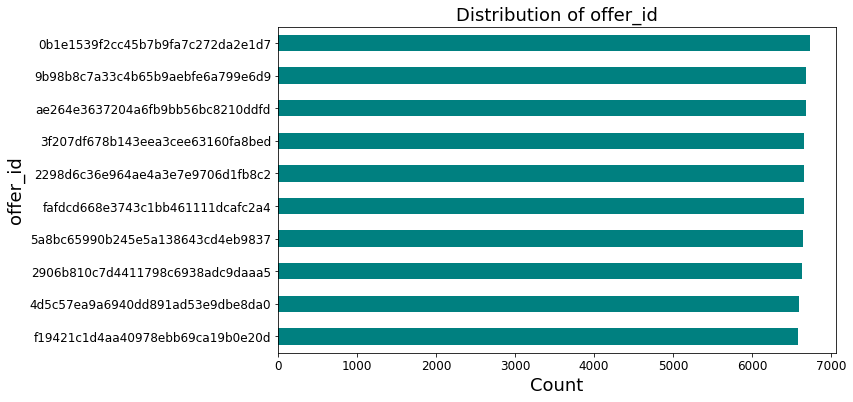

In [128]:
# Plot distribution of offer_id 
combined_data_df.groupby(['offer_id'])['cust_response'].count().sort_values(ascending=True).plot.barh(figsize=(10,6),\
                                                                                                    fontsize=12,color='teal');
plt.xlabel('Count', fontsize=18)
plt.ylabel('offer_id', fontsize=18)
plt.title('Distribution of offer_id', fontsize=18)
plt.show()

**From above, we can observe that the distribution of offers sent to customers are nearly and distribution is uniform**.

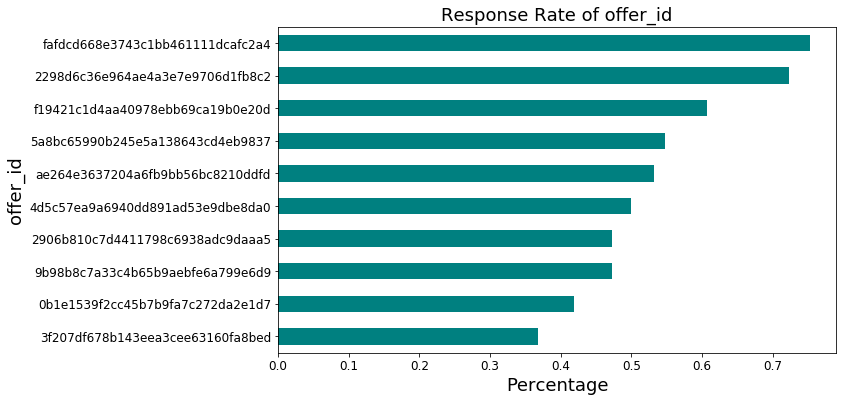

In [129]:
# Plot distribution of response_rate
response_rate.sort_values(ascending=True).plot.barh(figsize=(10,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
plt.ylabel('offer_id', fontsize=18)
plt.title('Response Rate of offer_id', fontsize=18)
plt.show()

**From above, we can observe that offer with offer_id as fafdcd668e3743c1bb461111dcafc2a4 having offer type as 'discount' got the highest response from customers with 76% response rate whereas offer with offer_id as 3f207df678b143eea3cee63160fa8bed with offer type as 'informational' got the lowest response from the customers with 37% response rate**.

In [130]:
# Check details of the offers with highest response rate
offer_high_resp = portfolio[portfolio['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']
offer_high_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
6,fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1


In [131]:
# Check details of the offers with highest response rate
offer_low_resp = portfolio[portfolio['offer_id'] == '3f207df678b143eea3cee63160fa8bed']
offer_low_resp

,offer_id,difficulty,duration,reward,bogo,discount,informational,web,email,mobile,social
2,3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0


#### Analyze Offer with highest response rate

In [132]:
# Analyze Offer with highest response rate
offer_id_high_resp = offer_high_resp['offer_id'].values[0]
offer_id_high_resp

'fafdcd668e3743c1bb461111dcafc2a4'

In [133]:
# Analyze Offer with lowest response rate
offer_id_low_resp = offer_low_resp['offer_id'].values[0]
offer_id_low_resp

'3f207df678b143eea3cee63160fa8bed'

In [134]:
# Create dataframe for high response and low resposne
combined_data_high_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_high_resp,:]
combined_data_low_resp_df = combined_data_df.loc[combined_data_df['offer_id'] == offer_id_low_resp,:]

In [135]:
# Create dataframe for customers for offers with high response rate whom responded to offer
# and whom did not responded to offer
cust_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 1,:]
cust_not_responded_high_rep_df = combined_data_high_resp_df.loc[combined_data_high_resp_df['cust_response'] == 0,:]

#### Compare gender distribution of customers in offers with highest response whom responded and whom did not responded

In [136]:
# Calculate percentage of each gender in highest response offer for customers whom responded
round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    44.18
M    54.52
O     1.30
dtype: float64

In [137]:
# Calculate percentage of each gender in lowest response offer for customers whom did not responded
round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2)

F    29.45
M    69.15
O     1.39
dtype: float64

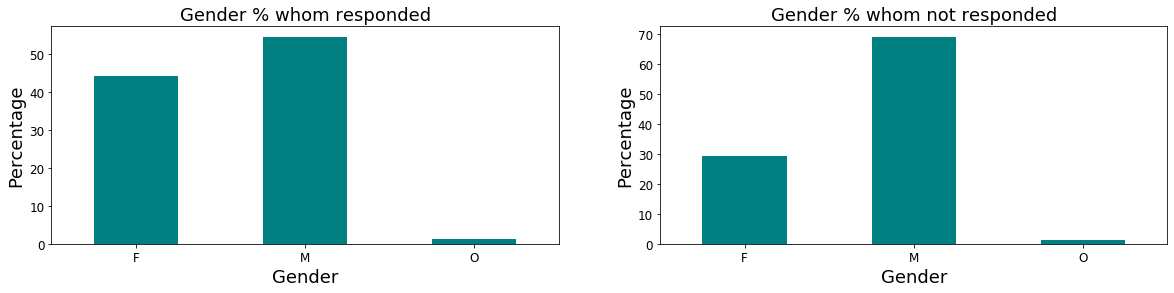

In [138]:
# Compare gender distribution in offers with highest response when offer was successful and unsuccessful
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(20,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom responded', fontsize=18)


plt.subplot(122)
round(cust_not_responded_high_rep_df[['F', 'M', 'O']].mean()*100,2).plot.bar(figsize=(20,4), fontsize=12,color='teal');
plt.xlabel('Gender', fontsize=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage', fontsize=18)
plt.title('Gender % whom not responded', fontsize=18)

plt.show()

**From above, we can observe that males responded more in successful & unsuccessful offers**.

#### Compare age distribution of customers in offers with highest response whom responded and whom did not responded

In [139]:
# Calculate percentage of each age group in highest response offer when offer was sucessful
age_grp_list = ['age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s']
round(cust_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      0.96
age_20s      8.24
age_30s     10.34
age_40s     14.77
age_50s     24.99
age_60s     21.39
age_70s     11.58
age_80s      5.84
age_90s      1.68
age_100s     0.22
dtype: float64

In [140]:
# Calculate percentage of each age group in highest response offer when offer was unsucessful
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2)

age_10s      1.94
age_20s     12.73
age_30s     10.97
age_40s     17.33
age_50s     19.58
age_60s     19.64
age_70s     12.00
age_80s      4.12
age_90s      1.58
age_100s     0.12
dtype: float64

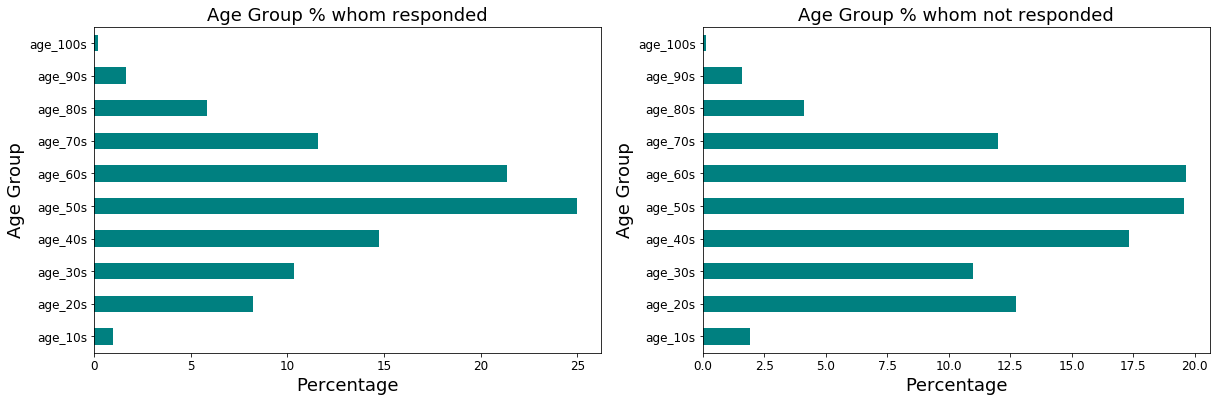

In [141]:
# Compare age group distribution in offers with highest response when offer was successful and unsuccessful
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[age_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Age Group', fontsize=18)
plt.title('Age Group % whom responded', fontsize=18)


plt.subplot(122)
round(cust_not_responded_high_rep_df[age_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Age Group', fontsize=18)
plt.title('Age Group % whom not responded', fontsize=18)

plt.show()

**Again, from above, we can observe that higher percentage of age distribution is 25% for age group age_50s when offer is successful and higher percentage of age distribution is 20% for age groups age_50s & age_60s when offer is unsuccessful**.

#### Compare income distribution of customers in offers with highest response whom responded and whom did not responded

In [142]:
# Calculate percentage of each income group in highest response offer when offer was sucessful
income_grp_list = ['income_30ths', 'income_40ths', 'income_50ths', 'income_60ths','income_70ths', 'income_80ths',\
                   'income_90ths', 'income_100ths', 'income_110ths', 'income_120ths']
round(cust_responded_high_rep_df[income_grp_list].mean()*100,2)

income_30ths     11.22
income_40ths     10.92
income_50ths     17.09
income_60ths     15.89
income_70ths     16.83
income_80ths     10.96
income_90ths      8.38
income_100ths     4.50
income_110ths     4.18
income_120ths     0.04
dtype: float64

In [143]:
# Calculate percentage of each income group in highest response offer when offer was unsucessful
round(cust_not_responded_high_rep_df[income_grp_list].mean()*100,2)

income_30ths     18.97
income_40ths     16.12
income_50ths     19.64
income_60ths     17.58
income_70ths     12.67
income_80ths      5.33
income_90ths      6.18
income_100ths     1.76
income_110ths     1.70
income_120ths     0.06
dtype: float64

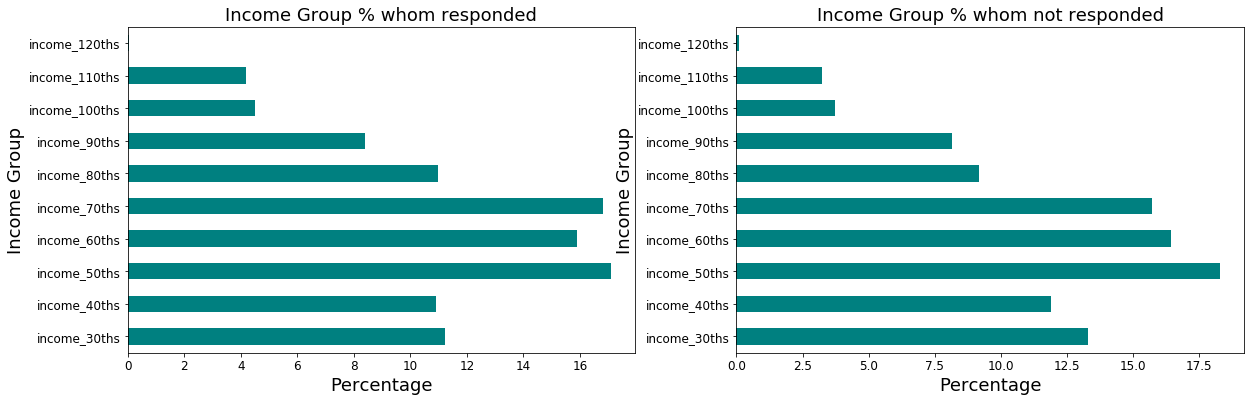

In [144]:
# Compare income group distribution in offers with highest response when offer was successful and unsuccessful
fig, ax = plt.subplots(figsize=(20, 6),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.subplot(121)
round(cust_responded_high_rep_df[income_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Income Group', fontsize=18)
plt.title('Income Group % whom responded', fontsize=18)


plt.subplot(122)
round(combined_data_low_resp_df[income_grp_list].mean()*100,2).plot.barh(figsize=(20,6), fontsize=12,color='teal');
plt.xlabel('Percentage', fontsize=18)
#plt.xticks(rotation='horizontal')
plt.ylabel('Income Group', fontsize=18)
plt.title('Income Group % whom not responded', fontsize=18)

plt.show()

**Again, from above, we can observe that higher percentage of income distribution is 17% for income group income_50ths & income_70ths when offer is successful and higher percentage of income distribution is 19% for age groups income_50ths & income_60ths when offer is unsuccessful**.

### Split the combined data into training and test data

**Before splitting the combined data, let us drop the features from combined data which would not play any role in training the model**.

In [145]:
# Drop features from combined_data_df which are not required for training the model
# Drop 'customer_id' & 'offer_id' as these are unique identifier
# Drop 'time' as it is not rqeuired. It was used to check if a customer responded to an offer or not
# and to calculate total amount
# Drop 'email' as it has only 1 value in all the observations and the value is 1
combined_data_df.drop(columns=['customer_id', 'offer_id', 'time', 'email'], inplace=True)
combined_data_df.head()

,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,membership_tenure,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,5,168,5,1,0,0,1,1,0,1671,...,0,0,0,0,0,1,0,0,37.67,1
1,0,72,0,0,0,1,0,1,1,1671,...,0,0,0,0,0,1,0,0,49.39,1
2,10,168,10,1,0,0,0,1,1,1671,...,0,0,0,0,0,1,0,0,48.28,1
3,5,120,5,1,0,0,1,1,1,1671,...,0,0,0,0,0,1,0,0,48.28,1
4,10,168,2,0,1,0,1,1,0,1319,...,0,0,1,0,0,0,0,0,0.00,0


In [146]:
# Separate features and labels of combined_data_df
X = combined_data_df.drop(columns=['cust_response'])
y = combined_data_df.loc[:,['cust_response']]

In [147]:
# Distribution of target class
y.squeeze().value_counts()

1    35854
0    30647
Name: cust_response, dtype: int64

In [148]:
# percenatge of distribution of target class
round((y.squeeze().value_counts()/y.squeeze().count())*100,2)

1    53.91
0    46.09
Name: cust_response, dtype: float64

**From above, we can observe that our dataset is nearly balanced (slightly imbalanced) in terms of distribution of target class as our target class has nearly equal number of customers whom responded to offer(53.91%) and whom did not responded to an offer(46.09%).**

In [149]:
# Split features and labels into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [150]:
X_train.head()

,difficulty,duration,reward,bogo,discount,informational,web,mobile,social,membership_tenure,...,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount
3422,0,96,0,0,0,1,1,1,0,2330,...,1,0,0,0,0,0,0,0,0,3.21
64365,10,168,10,1,0,0,0,1,1,1717,...,0,0,1,0,0,0,0,0,0,109.55
64981,10,168,2,0,1,0,1,1,0,1421,...,0,0,0,1,0,0,0,0,0,87.60
59855,5,120,5,1,0,0,1,1,1,1911,...,0,1,0,0,0,0,0,0,0,55.47
27439,0,72,0,0,0,1,0,1,1,2306,...,0,1,0,0,0,0,0,0,0,46.86


### Scale selected features

In [151]:
# Prepare list of features to scale
feat_to_scale = ['difficulty', 'duration', 'reward', 'membership_tenure', 'total_amount']

In [152]:
# Prepare a function func_feat_scale to scale features in train and test set
def func_feat_scale(df, feat=feat_to_scale):
        """
    Scale list features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        # Prepare dataframe of only features to scale
        df_feat_scale = df.loc[:,feat]
        
        # Apply feature scaling to df
        scaler = MinMaxScaler()
        df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,\
                                     index=df_feat_scale.index)
        
        # Drop orignal features to scale from df and add scaled features back to df
        df = df.drop(columns=feat, axis=1)
        df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
        return df_scaled

In [153]:
# Scale selected features in training set i.e. X_train
X_train_scaled = func_feat_scale(X_train, feat=feat_to_scale)
X_train_scaled.head()

,bogo,discount,informational,web,mobile,social,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,membership_tenure,total_amount
3422,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0.00,0.142857,0.0,0.604498,0.002862
64365,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.268239,0.097662
64981,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,0.2,0.105869,0.078094
59855,1,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.374657,0.049450
27439,0,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0.00,0.000000,0.0,0.591333,0.041775


In [154]:
# Print shape of dataframe X_train_scaled
X_train_scaled.shape

(49875, 52)

In [155]:
# Print shape of y_train
y_train.shape

(49875, 1)

In [156]:
# Distribution of the target class in training set
y_train.squeeze().value_counts()

1    26834
0    23041
Name: cust_response, dtype: int64

In [157]:
# Percenatge of distribution of the target class in training set
round((y_train.squeeze().value_counts()/y_train.squeeze().count())*100,2)

1    53.8
0    46.2
Name: cust_response, dtype: float64

**From above, we can observe that our training dataset is nearly balanced with approx. equal number of classes i.e. our training dataset has nearly equal number of customers whom responded to an offer (53.8%) and customers whom did not responded to an offer (46.2%). Since, our training dataset is nearly balanced, we do not have to deal with techniques to combat class imbalance. To know more about class imbalance and how to deal with it, refer [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).**

In [158]:
# Distribution of the target class in test set
y_test.squeeze().value_counts()

1    9020
0    7606
Name: cust_response, dtype: int64

In [159]:
# Distribution of the target class in test set
round((y_test.squeeze().value_counts()/y_test.squeeze().count())*100,2)

1    54.25
0    45.75
Name: cust_response, dtype: float64

**From above, we can observe that our test dataset is also nearly balanced in terms of distribution of target class.**

## Train the classifier

### Select the performance matrix

***Since, our training set is nearly balanced (slightly imbalanced) in terms of distribution of target class, performance metrics like accuracy, precision, recall, and f1_score are good measure for evaluating a model. For this case, evaluating a model with precision and recall would provide better insight to its performance rather than accuracy as dataset is slightly imbalanced. Because, Starbucks would like to send offers to those customers whom have more chances of redeeming the offers rather than to send offers to all customers which inturn would allow Starbucks to have efficient marketing and would be able to achieve more value for business from the offers. F1-score metric is "the harmonic mean of the precision and recall metrics" and is better way of providing greater predictive power on the problem and how good the predictive model is making predictions.
Refer [Classification Accuracy is Not Enough: More Performance Measures You Can Use](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for more information***.

In [160]:
# Create a baseline model against which we would compare our model to determine
# if our model is performing better than baseline model or not
# Our baseline model would predict that all users would respond to the offer
# So, we will calculate f1_score of the baseline model

baseline_model_f1_score = f1_score(y_train.squeeze().values, np.ones(y_train.shape[0]))
print('baseline model have f1_score: {}'.format(round(baseline_model_f1_score,4)))

baseline model have f1_score: 0.6996


**Our base model produced f1_score of 0.6996. Therefore, our other trained classifier should produce better f1_score than the threshold f1_score of 0.6996.**

In [161]:
# Define fit_classifier function to fit different classifiers on training dataset i.e. X_train_scaled
# to find the best performing classifier algorithm
def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):
    """
    Fits a classifier to its training data using GridSearchCV and calculates f1_score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train_scaled (DataFrame): training features
    - y_train (DataFrame): training label
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [162]:
# Initialize classification algorithms
lor = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier

In [163]:
# Find best classification algorithm
clf_names = []
clf_scores = []
clf_best_ests = []
clf_time_taken = []
clf_dict = {}

for clf in [lor, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(clf, {})
    clf_names.append(clf.__class__.__name__)
    clf_scores.append(best_score)
    clf_best_ests.append(best_est)
    clf_time_taken.append(time_taken)

Training LogisticRegression :


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

LogisticRegression
Time taken : 5.21 secs
Best f1_score : 0.8429
****************************************
Training RandomForestClassifier :


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

RandomForestClassifier
Time taken : 4.82 secs
Best f1_score : 0.9216
****************************************
Training AdaBoostClassifier :


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cur

AdaBoostClassifier
Time taken : 20.31 secs
Best f1_score : 0.896
****************************************
Training GradientBoostingClassifier :


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

GradientBoostingClassifier
Time taken : 81.74 secs
Best f1_score : 0.9209
****************************************


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool


In [164]:
# Create clf_df dataframe from clf_dict
clf_dict['best_f1_score'] = clf_scores
clf_dict['time_taken(s)'] = clf_time_taken
clf_dict['best_est'] = clf_best_ests
clf_df = pd.DataFrame(clf_dict, index=clf_names)
clf_df

,best_f1_score,time_taken(s),best_est
LogisticRegression,0.842906,5.21,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.921561,4.82,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.896027,20.31,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.920881,81.74,([DecisionTreeRegressor(criterion='friedman_ms...


**From above, we can observe that the all our trained classifier produce better f1_score than the threshold f1_score of 0.6996.
RandomForestClassifier and GradientBoostingClassifier has nearly equal f1_score(approx. 0.92) but RandomForestClassifier take very less time to train than the GradientBoostingClassifier. Therefore, best performing classifier algorithm among the above 4 classifiers is RandomForestClassifier.**

In [165]:
# Print the best estimator of RandomForestClassifier
clf_df.loc['RandomForestClassifier', 'best_est']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [166]:
# Print the classes known to the best estimator of RandomForestClassifier
clf_df.loc['RandomForestClassifier', 'best_est'].classes_

array([0, 1])

### Fine tune the trained model

In [167]:
# Tune the best classifier(RandomForestClassifier) with the help of param grid in GridSearchCV
# The fine tuned model will be used with the test set
param_grid = {#'n_estimators': [10, 50, 80, 100],
              'n_estimators': [50],
              #'max_depth': [None, 2, 3, 4],
              'max_depth': [None],
              #'min_samples_split': [2,3,4],
              'min_samples_split': [3],
              #'min_samples_leaf': [1,2,3],
              'min_samples_leaf': [1]
             }

rfc = RandomForestClassifier(random_state=42)
rfc_best_score, rfc_best_est, _ = fit_classifier(rfc, param_grid)
rfc_best_est

Training RandomForestClassifier :


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. I

RandomForestClassifier
Time taken : 19.37 secs
Best f1_score : 0.9319
****************************************


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**From above, we can observe that after fine tuning the trained RandomForestClassifier, we get improved and more better f1_score of 0.9319**.

### Feature Importances given by best estimator of trained model

In [168]:
# Print RandomForestClassifier best estimator feature importances
rfc_best_est.feature_importances_

array([4.73778202e-03, 4.88131414e-03, 5.31021640e-03, 5.14710721e-03,
       4.64540668e-03, 1.86772350e-02, 6.82320425e-03, 7.27729138e-03,
       1.14704517e-03, 1.75422080e-03, 5.84117391e-03, 5.58822964e-03,
       6.47512543e-03, 7.51663834e-03, 7.36934003e-03, 6.07272091e-03,
       4.19019093e-03, 2.16191356e-03, 1.30503797e-04, 1.17601710e-03,
       2.29013947e-03, 4.19585024e-03, 1.04213591e-02, 4.65628201e-03,
       1.23648035e-02, 4.25730593e-03, 3.86961636e-03, 4.20549488e-03,
       4.32480661e-03, 4.21046041e-03, 4.11720635e-03, 4.33477372e-03,
       4.42233119e-03, 4.44105960e-03, 4.48856380e-03, 4.56184607e-03,
       4.46509981e-03, 7.92205269e-03, 6.77998684e-03, 6.16906698e-03,
       5.49462117e-03, 5.77049450e-03, 5.16543536e-03, 4.59383635e-03,
       3.48839480e-03, 3.85458082e-03, 2.52440068e-04, 1.60824526e-02,
       1.55237721e-02, 1.45034138e-02, 9.36572503e-02, 6.18192526e-01])

In [169]:
# Print shape of RandomForestClassifier best estimator feature importances
rfc_best_est.feature_importances_.shape

(52,)

In [170]:
# Prepare the dataframe of feature importances given to features by best estimator of RandomForestClassifier
feat_imp_df = pd.DataFrame(rfc_best_est.feature_importances_,\
                           index=X_train_scaled.columns.tolist(),\
                           columns=['feat_imp']).reset_index()

feat_imp_df.rename(columns={'index': 'feature'}, inplace=True)
feat_imp_df['feat_imp_perc'] = np.round((feat_imp_df['feat_imp']/feat_imp_df['feat_imp'].sum())*100,2)
feat_imp_df = feat_imp_df.sort_values(by=['feat_imp_perc'], ascending=False).reset_index(drop=True)
feat_imp_df

,feature,feat_imp,feat_imp_perc
0,total_amount,0.618193,61.82
1,membership_tenure,0.093657,9.37
2,social,0.018677,1.87
3,difficulty,0.016082,1.61
4,duration,0.015524,1.55
5,reward,0.014503,1.45
6,2018,0.012365,1.24
7,2016,0.010421,1.04
8,income_30ths,0.007922,0.79
9,age_50s,0.007517,0.75


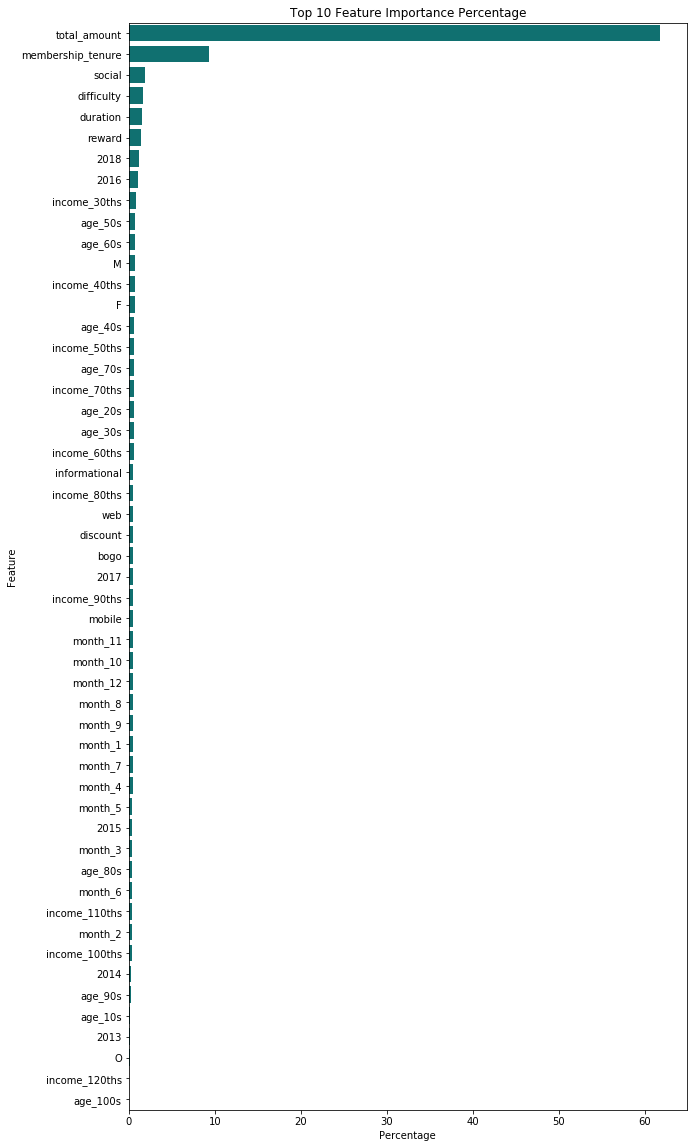

In [171]:
# Plot horizontal bar graph of features with their importances given by best estimator of RandomForestClassifier
fig, ax = plt.subplots(figsize=(10, 20),
                       nrows=1,
                       ncols=1)

sns.barplot(x='feat_imp_perc', y='feature', color='teal', data=feat_imp_df)
plt.xlabel('Percentage')
#plt.xticks(rotation='horizontal')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance Percentage')
plt.show()

In [172]:
# Print top 10 features
feat_imp_df[:10]

,feature,feat_imp,feat_imp_perc
0,total_amount,0.618193,61.82
1,membership_tenure,0.093657,9.37
2,social,0.018677,1.87
3,difficulty,0.016082,1.61
4,duration,0.015524,1.55
5,reward,0.014503,1.45
6,2018,0.012365,1.24
7,2016,0.010421,1.04
8,income_30ths,0.007922,0.79
9,age_50s,0.007517,0.75


From above, we can observe the following:
* Top 10 features which influence whether the customer will respond to an offer or not after viewing the offer are: `'total_amount', 'membership_tenure' , 'social', 'difficulty', 'duration', 'reward', '2018', '2016', 'income_30ths'` and `'age_50s'`.
* `total_amount` spent by the customer is the biggest and largest feature which could one sided influence if the customer will complete an offer after viewing the offer i.e. how much a customer spend is likely to decide if a customer will complete an offer. Therefore, knowing how much a customer can spend beforehand can definitely help in determining if a customer will respond to an offer and complete it. For this, another supervised learning algorithms i.e. regression models would be required in order to predict the total amount an individual could spend based on offer data and customer demographic data.
* After `'total_amount'`, `'membership_tenure'` is the second largest feature - which represents, how long the customer has been the member of Starbucks reward program heavily influence if the customer will complete an offer after responding to it.
* After `'membership_tenure'`, `'social feature'` - which represents, if Starbucks sent the offer to customer via social media is likely to be responded more that other mode of communication.
* After `'social'` feature, the `'difficulty'` feature - which represents, minimum amount to spent in order to complete the offer influence if the customer would response and complete the offer.
* After `'difficulty'` feature, `'duration'` feature - which represents, how long the offer is valid influence the customer response and completion of the offer.
* After `'duration'` feature, `'reward'` feature - which represents, how much amount as a reward, a customer is getting back influence if the customer would response and complete the offer.
* After `'reward'` feature, `'2018'` and `'2016'` feature, which represents - if a customer became member of Starbucks reward program in years 2016 & 2018, had more chance of responding to an offer and completing it.
* After `'2018'` and `'2016'` feature, `'income_30ths'` feature, which represents - if customer's income is in 30000's which is the starting income group, then customer is likely to respond more to an offer and complete it.
* After `'income_30ths` feature, `'age_50s'` feature which represents - if the customer age is in 50's, then customer is likely to respond more to an offer and complete it.

### Predict classes for the test data

In [173]:
# Prepare test data in order to predict classes for the test data
# Scale selected features in test set i.e. X_test
X_test_scaled = func_feat_scale(X_test, feat=feat_to_scale)
X_test_scaled.head()

,bogo,discount,informational,web,mobile,social,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,membership_tenure,total_amount
20034,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0.25,0.571429,0.5,0.503017,0.004838
55752,1,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.815688,0.016028
61495,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.399342,0.016362
34391,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.116292,0.000000
36619,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.149205,0.000669


In [174]:
# Print shape of dataframe X_test_scaled
X_test_scaled.shape

(16626, 52)

In [175]:
# Print shape of y_test
y_test.shape

(16626, 1)

In [176]:
# Classification of test data using best model trained on train data
y_pred = rfc_best_est.predict(X_test_scaled)
y_pred

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


array([0, 1, 1, ..., 0, 0, 1])

In [177]:
# Print shape of y_pred
y_pred.shape

(16626,)

### Confusion Matrix

In [178]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, y_pred)

array([[6733,  873],
       [ 360, 8660]])

In [179]:
# Calculate tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 6733
false postives: 873
false negatives: 360
true postives: 8660


In [180]:
# Calculate precision, recall and f1_score of the test data
test_data_f1_score = f1_score(y_test.squeeze().values, y_pred)
test_data_precision_score = precision_score(y_test.squeeze().values.tolist(), y_pred)
test_data_recall_score = recall_score(y_test.squeeze().values, y_pred)
print('f1_score on test data: {}'.format(round(test_data_f1_score,4)))
print('precision score on test data: {}'.format(round(test_data_precision_score,4)))
print('recall score on test data: {}'.format(round(test_data_recall_score,4)))

f1_score on test data: 0.9335
precision score on test data: 0.9084
recall score on test data: 0.9601


**From above, we observe that the trained RandomForestClassifier best estimator produced f1_score of 0.9336 on test data, which is quite good.**

In [181]:
# Define function plot_confusion_matrix which plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    - y_true (np.array): array containing true labels
    - y_pred (np.array): array containing predicted labels
    - normalize (boolean): boolean value to determine whether to normalize the confusion matrix or not
    - title (str): title to use in confusion matrix plot
            
    OUTPUT:
    - ax (Axes object): Axes object to plot confusion matrix plot
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[6733  873]
 [ 360 8660]]


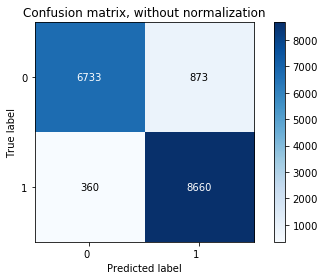

In [182]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
class_names = np.array([0, 1])

plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Normalized confusion matrix
[[0.89 0.11]
 [0.04 0.96]]


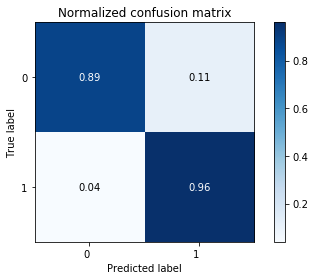

In [183]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.squeeze().values, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

**From above normalized confusion matrix, we observed that there are 4% of chances of misclassifying an indvidual whom would normally respond to an individual that would not respond to offer. Similarly, there are 11% of chances of misclassifying an individual whom would not respond to an individual whom would respond to an offer. As, False Negatives is less than False Positives, our predictive model is doing good as it has very low chances of missing an individual whom would respond. As Starbucks would not like to miss to send offers to individuals whom would respond to offers, this model would work fine in this case and by using this model Starbucks would not miss sending offers by great extent to individuals whom would respond to offers and therefore, overall business revenue would not get affected. Also, Starbucks would not mind sending offers to few individuals whom would not respond if Starbucks is able to make sure that they have covered up the individuals whom would respond to offers to great extent. Therefore, our predictive model is well suited for this case.**

### Reflection

The most interesting aspect of this project which I really liked was how different set of data i.e. offer data, customer demographic data and transcript data were combined to gain insights using predictive modeling techniques and analysis to provide better business decisions and value to the business. The toughest part of this entire analysis was finding logic and strategy to make combined dataset based on the duration of the offer when it was active for customers.

### Improvement

1.More feature engineering could be performed on offer, customer demographic and transaction data in order to have more better model.

2.Also, we can improve this project by taking up another problem statement i.e. determining how much a customer could spend based upon the offer data and demographic data using the supervised machine learning regression algorithms which inturn would help in finding out if the customer would respond or not as ‘total amount’ which a customer could spend is the top most feature in the best trained classifier model.

3.Also, we can improve the project by making our nearly balanced (slightly imbalanced) dataset into a perfectly balanced dataset using [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). This would further improve the performance of classification model.

4.We can also perform the clustering modeling (behavioral clustering, product-based clustering, brand-based clustering) for customer segmentation into groups based on several variables at once. With it, we can target specific demographics and personas for different targets.